In [24]:
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

app_dir = '/Users/nikhilvs/repos/nyu/covid-19'

In [3]:
df = pd.read_csv(os.path.join(app_dir, 'data/staging/unified.csv'))
country_df = df[df['country_region'] == 'Spain']

In [166]:
list(df.columns)

['country_region',
 'date',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'E1_Income support',
 'E2_Debt/contract relief',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'H3_Contact tracing',
 'StringencyIndex',
 'cases',
 'cases_lag_1',
 'cases_lag_2',
 'cases_lag_3',
 'cases_lag_4',
 'cases_lag_5',
 'cases_lag_6',
 'cases_lag_7',
 'cases_lag_8',
 'cases_lag_9',
 'cases_lag_10',
 'cases_lag_11',
 'cases_lag_12',
 'cases_lag_13',
 'cases_lag_14',
 'cases_lag_15',
 'cases_lag_16',
 'cases_lag

In [167]:
TRAIN_COLUMNS = [
    # 'country_region',
    # 'date',
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'C1_School closing',
    'C2_Workplace closing',
    'C3_Cancel public events',
    'C4_Restrictions on gatherings',
    'C5_Close public transport',
    'C6_Stay at home requirements',
    'C7_Restrictions on internal movement',
    'C8_International travel controls',
    'E1_Income support',
    'E2_Debt/contract relief',
    'H1_Public information campaigns',
    'H2_Testing policy',
    'H3_Contact tracing',
    'StringencyIndex',
    'population_density',
    # 'cases_lag_1',
    # 'cases_lag_2',
    # 'cases_lag_3',
    # 'cases_lag_4',
    # 'cases_lag_5',
    # 'cases_lag_6',
    'cases_lag_7',
    'cases_lag_8',
    'cases_lag_9',
    'cases_lag_10',
    'date+1_pred',
    'date+2_pred',
    'date+3_pred',
    'date+4_pred',
    'date+5_pred',
    'date+6_pred',
    'date+7_pred',
    'date+8_pred',
    'date+1_linf',
    'date+2_linf',
    'date+3_linf',
    'date+4_linf',
    'date+5_linf',
    'date+6_linf',
    'date+7_linf',
    'date+8_linf',
    'date+1_lsup',
    'date+2_lsup',
    'date+3_lsup',
    'date+4_lsup',
    'date+5_lsup',
    'date+6_lsup',
    'date+7_lsup',
    'date+8_lsup'
]

TARGET_COLUMNS = [
    'cases'
]

COUNTRIES = [
    'United States', 
    'India', 
    'Italy', 
    'Canada', 
    'Spain', 
    'France', 
    'United Kingdom',
    'Iraq',
    'Japan',
    'South Korea',
    'Germany',
    'Brazil'
]

In [168]:
# for SHIFT_IMPACT_DAYS in list(range(1, 10)):
SHIFT_IMPACT_DAYS = 8
all_countries_df = None

for country in COUNTRIES:
    country_shifted_df = df[df['country_region'] == country].copy()

    SHIFT_COL_TARGET = 'cases_' + str(SHIFT_IMPACT_DAYS)
    country_shifted_df[SHIFT_COL_TARGET] = country_shifted_df['cases'].shift(-SHIFT_IMPACT_DAYS)

    for lag in range(1, 11):
        SHIFT_COL = f'cases_lag_{lag}_' + str(SHIFT_IMPACT_DAYS)
        country_shifted_df[SHIFT_COL] = country_shifted_df[f'cases_lag_{lag}'].shift(-SHIFT_IMPACT_DAYS)

    country_shifted_df = country_shifted_df.dropna()
    if all_countries_df is None:
        all_countries_df = pd.DataFrame(columns = country_shifted_df.columns)
    
    all_countries_df = all_countries_df.append(country_shifted_df)



In [169]:
train_subset = all_countries_df[all_countries_df['date'] <= '2020-04-25']
test_subset = all_countries_df[all_countries_df['date'] > '2020-04-25']

X_train = train_subset[TRAIN_COLUMNS]
y_train = train_subset[SHIFT_COL_TARGET]
X_test = test_subset[TRAIN_COLUMNS]
y_test = test_subset[SHIFT_COL_TARGET]

poly = PolynomialFeatures(3)

X_train_poly = poly.fit_transform(X_train)
scaler = preprocessing.StandardScaler().fit(X_train_poly)

X_train_poly = scaler.transform(X_train_poly)
X_test_poly = scaler.transform(poly.fit_transform(X_test))

# reg = LinearRegression().fit(X_train_poly, y_train)
reg = Ridge(alpha = 10).fit(X_train_poly, y_train)
print(reg.score(X_train_poly, y_train))
test_pred = reg.predict(X_test_poly)
print(mean_squared_error(y_test, test_pred))
print(r2_score(y_test, test_pred))

train_pred = reg.predict(X_train_poly)

0.9998531917499518
164815989.9177677
0.9984940559260069


In [170]:
all_countries = train_subset['country_region'].append(test_subset['country_region'])
all_preds = np.append(train_pred, test_pred)
all_gt = y_train.append(y_test)

test_countries = test_subset['country_region']
countries_with_preds = pd.DataFrame(data = {
    'country' : all_countries,
    'preds' : all_preds,
    'gt': all_gt
})


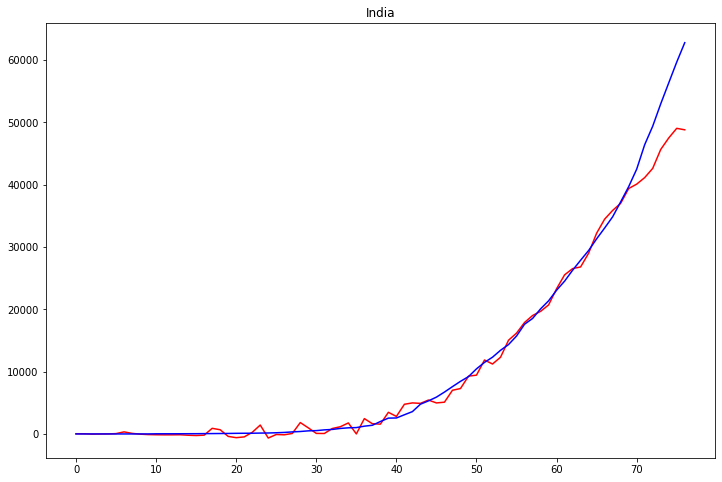

In [171]:
country_preds = countries_with_preds[countries_with_preds['country'] == 'India']
dates = np.arange(country_preds.shape[0])
plt.figure(figsize = (12, 8))
plt.title('India')
plt.plot(dates, country_preds['preds'], 'r-')
plt.plot(dates, country_preds['gt'], 'b-')

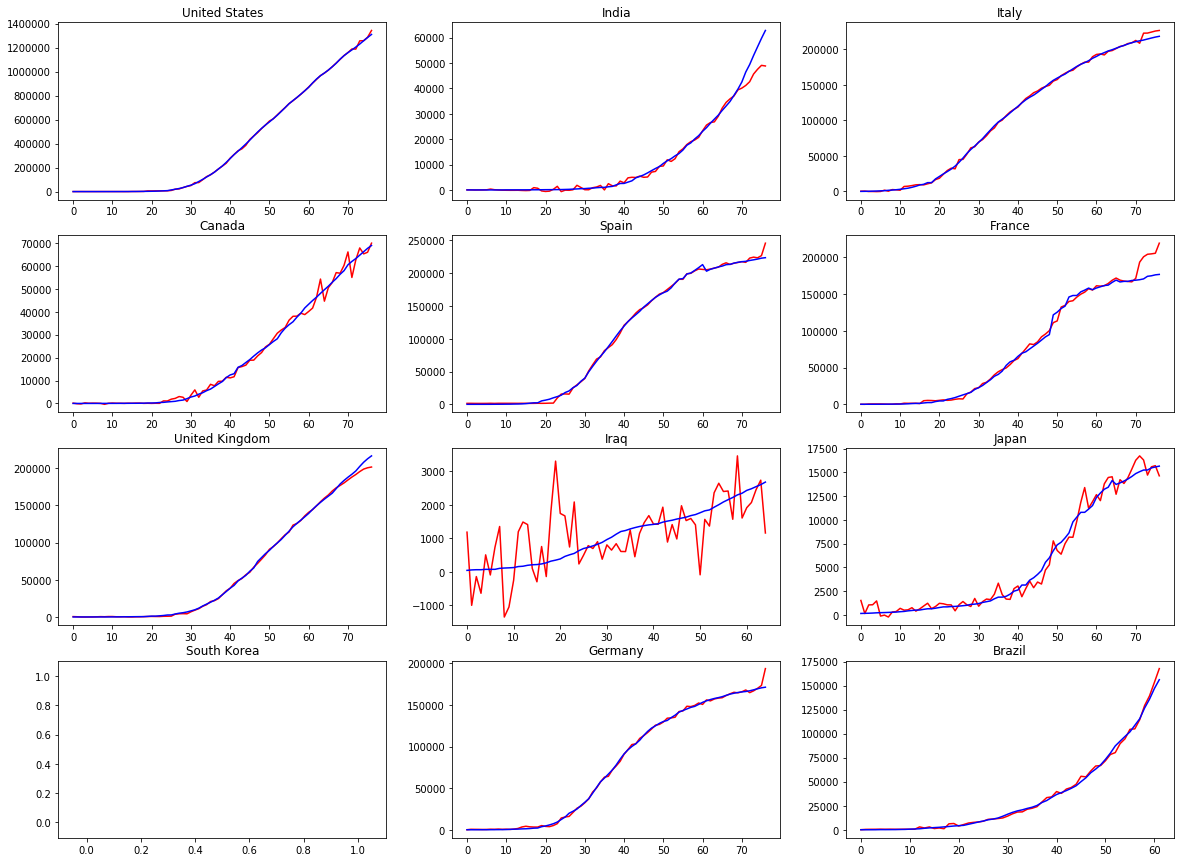

In [172]:
fig, (
    (ax11, ax12, ax13), 
    (ax21, ax22, ax23),
    (ax31, ax32, ax33),
    (ax41, ax42, ax43)
) = plt.subplots(4, 3)
# fig.suptitle('Sharing x per column, y per row')

fig.set_figwidth(20)
fig.set_figheight(15)
axes = [ax11, ax12, ax13, ax21, ax22, ax23, ax31, ax32, ax33, ax41, ax42, ax43]
countries = COUNTRIES

for country, ax in zip(countries, axes):
    country_preds = countries_with_preds[countries_with_preds['country'] == country]
    dates = np.arange(country_preds.shape[0])
    ax.plot(dates, country_preds['preds'], 'r-')
    ax.plot(dates, country_preds['gt'], 'b-')
    ax.set_title(country)